In [1]:
import numpy as np
import pandas as pd
import os
from xgboost.sklearn import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# read from level file
level = pd.read_csv('../../dataset/data_xyz/provinceData/level.csv')
gdp = pd.read_csv('../../dataset/gdp_2021.csv')
population_density = pd.read_csv('../../dataset/population_density.csv')
population7th = pd.read_csv('../../dataset/population7th.csv')
aging_rate_2021 = pd.read_csv('../../dataset/aging_rate_2021.csv')
vaccinate = pd.read_csv('../../dataset/vaccinate/vaccinataion_china.csv')

In [3]:
def findAllFile(base):
    for root, ds, fs in os.walk(base):
        for f in fs:
            if f.endswith('.json'):
#                 yield f
                fullname = os.path.join(root, f)
                yield fullname,f

In [4]:
# load data from every province
province_days = []
province_names = []
base = '../../dataset/data_xyz/provinceData'
total_data = pd.DataFrame()
for i,f in findAllFile(base):
    # transform date
    data = pd.read_json(i)
    data = pd.json_normalize(data['data'])
    data['dateId'] = pd.to_datetime(data['dateId'], format='%Y%m%d')
    # transform end
    data['Province'] = f[:-5]
    province_days.append(data.shape[0])
    province_names.append(f[:-5])
    total_data = pd.concat([total_data,data],axis=0)

In [5]:
total_data.isnull().any()

confirmedCount           False
confirmedIncr            False
curedCount               False
curedIncr                False
currentConfirmedCount    False
currentConfirmedIncr     False
dateId                   False
deadCount                False
deadIncr                 False
highDangerCount          False
midDangerCount           False
suspectedCount           False
suspectedCountIncr       False
Province                 False
dtype: bool

In [6]:
total_data = pd.merge(total_data, level, on='Province', how='left')

In [7]:
total_data = pd.merge(total_data, gdp, on='Province', how='left')

In [8]:
total_data = pd.merge(total_data, population_density, on='Province', how='left')

In [9]:
total_data = pd.merge(total_data, population7th, on='Province', how='left')

In [10]:
total_data = pd.merge(total_data, aging_rate_2021, on='Province', how='left')

In [11]:
vaccinate = vaccinate.iloc[:,1:]

In [12]:
vaccinate['time'] = pd.to_datetime(vaccinate['time'], format='%Y-%m-%d')

In [13]:
vaccinate

,time,vaccination number (w)
0,2021-03-23,8284.60
1,2021-03-24,8585.97
2,2021-03-25,9134.60
3,2021-03-26,9747.00
4,2021-03-27,10241.70
...,...,...
237,2022-05-11,335712.00
238,2022-05-12,335857.60
239,2022-05-13,336005.00
240,2022-05-14,336133.30


In [14]:
total_data

,confirmedCount,confirmedIncr,curedCount,curedIncr,currentConfirmedCount,currentConfirmedIncr,dateId,deadCount,deadIncr,highDangerCount,midDangerCount,suspectedCount,suspectedCountIncr,Province,level,GDP,population_km,population,rate
0,9,9,0,0,9,9,2020-01-23,0,0,0,0,0,0,山东,4,83095.9,579.0,101527453,16.0
1,21,12,0,0,21,12,2020-01-24,0,0,0,0,0,0,山东,4,83095.9,579.0,101527453,16.0
2,39,18,0,0,39,18,2020-01-25,0,0,0,0,0,0,山东,4,83095.9,579.0,101527453,16.0
3,63,24,0,0,63,24,2020-01-26,0,0,0,0,0,0,山东,4,83095.9,579.0,101527453,16.0
4,87,24,0,0,87,24,2020-01-27,0,0,0,0,0,0,山东,4,83095.9,579.0,101527453,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29003,1383,0,1354,6,28,-6,2022-05-11,1,0,0,0,0,0,江西,4,29619.7,247.0,45188635,12.3
29004,1383,0,1361,7,21,-7,2022-05-12,1,0,0,0,0,0,江西,4,29619.7,247.0,45188635,12.3
29005,1383,0,1364,3,18,-3,2022-05-13,1,0,0,0,0,0,江西,4,29619.7,247.0,45188635,12.3
29006,1383,0,1369,5,13,-5,2022-05-14,1,0,0,0,0,0,江西,4,29619.7,247.0,45188635,12.3


In [15]:
total_data = pd.merge(total_data, vaccinate, left_on='dateId',right_on='time', how='left').drop(columns=['time']).fillna(method='bfill', limit=10).fillna(0)

In [16]:
total_data

,confirmedCount,confirmedIncr,curedCount,curedIncr,currentConfirmedCount,currentConfirmedIncr,dateId,deadCount,deadIncr,highDangerCount,midDangerCount,suspectedCount,suspectedCountIncr,Province,level,GDP,population_km,population,rate,vaccination number (w)
0,9,9,0,0,9,9,2020-01-23,0,0,0,0,0,0,山东,4,83095.9,579.0,101527453,16.0,0.0
1,21,12,0,0,21,12,2020-01-24,0,0,0,0,0,0,山东,4,83095.9,579.0,101527453,16.0,0.0
2,39,18,0,0,39,18,2020-01-25,0,0,0,0,0,0,山东,4,83095.9,579.0,101527453,16.0,0.0
3,63,24,0,0,63,24,2020-01-26,0,0,0,0,0,0,山东,4,83095.9,579.0,101527453,16.0,0.0
4,87,24,0,0,87,24,2020-01-27,0,0,0,0,0,0,山东,4,83095.9,579.0,101527453,16.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29038,1383,0,1354,6,28,-6,2022-05-11,1,0,0,0,0,0,江西,4,29619.7,247.0,45188635,12.3,335712.0
29039,1383,0,1361,7,21,-7,2022-05-12,1,0,0,0,0,0,江西,4,29619.7,247.0,45188635,12.3,335857.6
29040,1383,0,1364,3,18,-3,2022-05-13,1,0,0,0,0,0,江西,4,29619.7,247.0,45188635,12.3,336005.0
29041,1383,0,1369,5,13,-5,2022-05-14,1,0,0,0,0,0,江西,4,29619.7,247.0,45188635,12.3,336133.3


In [17]:
# Data cleaning now end, start to train module

In [18]:
province_days

[828,
 831,
 829,
 829,
 828,
 828,
 829,
 829,
 829,
 829,
 831,
 830,
 828,
 829,
 831,
 829,
 826,
 830,
 828,
 828,
 828,
 827,
 832,
 829,
 829,
 828,
 822,
 829,
 828,
 830,
 829,
 828,
 830,
 830]

In [19]:
# province_days diff in province may means that some days missing!!! In there, just ignore...

In [20]:
groups = total_data.groupby(total_data.Province)
province_data = []
for i in province_names:
    province_data.append(groups.get_group(i))
# province data get end

In [21]:
step1_data = []
for df in province_data:
    df_1 = df.shift(1)
    df_1.rename(columns=lambda x:str(x)+"1", inplace=True)
    step1_data.append(pd.concat([df, df_1], axis=1)[1:])

In [22]:
data_x_y = pd.concat(step1_data, axis=0)

In [23]:
data_x_y

,confirmedCount,confirmedIncr,curedCount,curedIncr,currentConfirmedCount,currentConfirmedIncr,dateId,deadCount,deadIncr,highDangerCount,...,midDangerCount1,suspectedCount1,suspectedCountIncr1,Province1,level1,GDP1,population_km1,population1,rate1,vaccination number (w)1
1,21,12,0,0,21,12,2020-01-24,0,0,0,...,0.0,0.0,0.0,山东,4.0,83095.9,579.0,101527453.0,16.0,0.0
2,39,18,0,0,39,18,2020-01-25,0,0,0,...,0.0,0.0,0.0,山东,4.0,83095.9,579.0,101527453.0,16.0,0.0
3,63,24,0,0,63,24,2020-01-26,0,0,0,...,0.0,0.0,0.0,山东,4.0,83095.9,579.0,101527453.0,16.0,0.0
4,87,24,0,0,87,24,2020-01-27,0,0,0,...,0.0,0.0,0.0,山东,4.0,83095.9,579.0,101527453.0,16.0,0.0
5,121,34,0,0,121,34,2020-01-28,0,0,0,...,0.0,0.0,0.0,山东,4.0,83095.9,579.0,101527453.0,16.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29038,1383,0,1354,6,28,-6,2022-05-11,1,0,0,...,0.0,0.0,0.0,江西,4.0,29619.7,247.0,45188635.0,12.3,335553.5
29039,1383,0,1361,7,21,-7,2022-05-12,1,0,0,...,0.0,0.0,0.0,江西,4.0,29619.7,247.0,45188635.0,12.3,335712.0
29040,1383,0,1364,3,18,-3,2022-05-13,1,0,0,...,0.0,0.0,0.0,江西,4.0,29619.7,247.0,45188635.0,12.3,335857.6
29041,1383,0,1369,5,13,-5,2022-05-14,1,0,0,...,0.0,0.0,0.0,江西,4.0,29619.7,247.0,45188635.0,12.3,336005.0


In [24]:
Y = data_x_y['currentConfirmedCount']
X = data_x_y[['confirmedCount1','confirmedIncr1','curedCount1','curedIncr1','currentConfirmedCount1','currentConfirmedIncr1','deadCount1','deadIncr1','highDangerCount1','midDangerCount1','suspectedCount1','suspectedCountIncr1','level1','GDP1','population_km1','population1','rate1']]

In [25]:
X

,confirmedCount1,confirmedIncr1,curedCount1,curedIncr1,currentConfirmedCount1,currentConfirmedIncr1,deadCount1,deadIncr1,highDangerCount1,midDangerCount1,suspectedCount1,suspectedCountIncr1,level1,GDP1,population_km1,population1,rate1
1,9.0,9.0,0.0,0.0,9.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,83095.9,579.0,101527453.0,16.0
2,21.0,12.0,0.0,0.0,21.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,83095.9,579.0,101527453.0,16.0
3,39.0,18.0,0.0,0.0,39.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,83095.9,579.0,101527453.0,16.0
4,63.0,24.0,0.0,0.0,63.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,83095.9,579.0,101527453.0,16.0
5,87.0,24.0,0.0,0.0,87.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,83095.9,579.0,101527453.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29038,1383.0,0.0,1348.0,16.0,34.0,-16.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,29619.7,247.0,45188635.0,12.3
29039,1383.0,0.0,1354.0,6.0,28.0,-6.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,29619.7,247.0,45188635.0,12.3
29040,1383.0,0.0,1361.0,7.0,21.0,-7.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,29619.7,247.0,45188635.0,12.3
29041,1383.0,0.0,1364.0,3.0,18.0,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,29619.7,247.0,45188635.0,12.3


In [26]:
train_X,test_X,train_y,test_y = train_test_split(X,Y,test_size=0.3, random_state=4)

In [27]:
le = LabelEncoder()
train_y = le.fit_transform(train_y)
test_y = le.fit_transform(test_y)

In [28]:
# model start
# xgboost
xgb_params = {
    'random_state': 1, 
    'n_jobs': 8,
    'booster': 'gbtree',
    'n_estimators': 10000,
    'tree_method': 'gpu_hist', 
    'gpu_id': 0,
    # optimized params
    'learning_rate': 0.03628302216953097,
    'reg_lambda': 0.0008746338866473539,
    'reg_alpha': 23.13181079976304,
    'subsample': 0.7875490025178415,
    'colsample_bytree': 0.11807135201147481,
    'max_depth': 3
}
clf = XGBRegressor(**xgb_params)

# clf = MLPRegressor(
#   hidden_layer_sizes=(1000,750,500,250,100,50),
#   activation='relu',
# #     solver='sgd',
#     alpha=0.01,
#     max_iter=1000,
#     early_stopping=True,
#     verbose=True,
# #     learning_rate_init=0.01
# )

In [29]:
clf.fit(train_X,
        train_y,
        eval_set=[(test_X,test_y)],
        early_stopping_rounds=300,
        verbose = 100
       )

/home/bill/.local/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:132.80026
[100]	validation_0-rmse:42.40452
[200]	validation_0-rmse:47.66443
[300]	validation_0-rmse:48.63517
[371]	validation_0-rmse:48.74851


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.11807135201147481, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=0,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.03628302216953097,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=3,
             max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=23.13181079976304, reg_lambda=0.0008746338866473539, ...)

In [30]:
train_X

,confirmedCount1,confirmedIncr1,curedCount1,curedIncr1,currentConfirmedCount1,currentConfirmedIncr1,deadCount1,deadIncr1,highDangerCount1,midDangerCount1,suspectedCount1,suspectedCountIncr1,level1,GDP1,population_km1,population1,rate1
23567,9074.0,25.0,8201.0,74.0,719.0,-50.0,154.0,1.0,0.0,0.0,176.0,0.0,1.0,23740.00,6512.68,7589499.0,18.2
14475,18.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3346.63,7.20,5923957.0,10.0
12769,68149.0,0.0,63637.0,0.0,0.0,0.0,4512.0,0.0,0.0,0.0,0.0,0.0,3.0,50012.94,325.00,57752557.0,14.8
2512,251.0,12.0,48.0,7.0,201.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,40391.30,355.00,74610235.0,15.0
16213,1044.0,0.0,1036.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,46063.09,304.00,66444864.0,15.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22428,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2080.17,2.10,3648100.0,5.7
17113,147.0,0.0,145.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,19586.42,200.00,38562148.0,11.8
27095,1612.0,0.0,1599.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,394.0,0.0,4.0,14879.20,81.00,31850088.0,16.8
8377,587.0,0.0,448.0,5.0,131.0,-5.0,8.0,0.0,0.0,0.0,164.0,0.0,5.0,40269.60,823.00,21893095.0,14.0


In [31]:
clf.predict(test_X)

array([17.414845, 13.278068, 93.34861 , ...,  9.838589, 89.91866 ,
       14.525977], dtype=float32)

In [32]:
test_y

array([ 4, 10, 48, ...,  0, 63,  4])

<IPython.core.display.Javascript object>


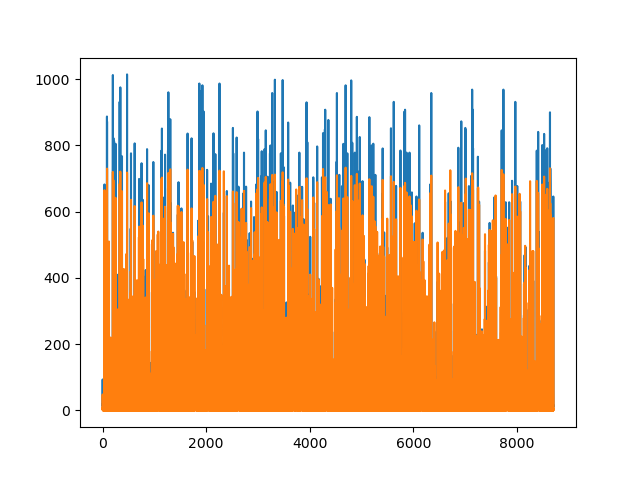

In [33]:
plt.plot(clf.predict(test_X))

In [34]:
plt.plot(test_y)

In [35]:
sum = 0
count = 0
for i in test_y-clf.predict(test_X):
    sum += abs(i)
    count += 1

In [36]:
sum / count

21.56156053886076